<Body>   
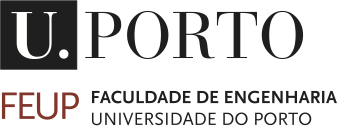   
<h1> <b>Perception and Mapping </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

### **Project Authors**

- **up202004966 - Bruno Filipe Torres Costa**
- **up201906003 - Pedro Miguel Oliveira Rodrigues**
---



# Enhancing Point Cloud Registration using the Robust Iterative Closest Point (R-ICP)

Point cloud registration is a fundamental task in computer vision and involves aligning two or more point clouds to find their relative transformation. The Iterative Closest Point (ICP) algorithm is widely used for this purpose. However, ICP is sensitive to outliers, noise, and initial alignment. In response to these limitations, the Robust Iterative Closest Point (Robust ICP) algorithm was developed. Robust ICP is designed to improve the accuracy and robustness of point cloud registration, even in the presence of challenging data.

One of the key challenges in point cloud registration is dealing with outliers. R-ICP is more resilient to noise in the data, making it suitable for real-world scenarios where data may be imperfect. The R-ICP addresses this challenge by explicitly considering the impact of outliers and assigning appropriate weights to data points. By iteratively refining the transformation estimate and focusing on inlier correspondences, Robust ICP often converges to more accurate solutions.

In [53]:
# Install Open3D library
!pip install open3d

In [54]:
# Import libraries
import numpy as np
import open3d as o3d
import copy

# Visualization
import plotly.graph_objects as go  # plotly to visualize since COLAB does not allow to use O3D functions
import matplotlib.pyplot as plt    # or, Matplotlib
from mpl_toolkits import mplot3d
from sklearn.neighbors import NearestNeighbors

In [55]:
# Visualize point cloud as a scatter plot using matplotlib (as an image!)
def plot_pointcloud_matplotlib_singleview (pt, title_ = ' ', view_ =(-90, 90, 0)):
  colors = None
  if pt.has_colors():
      colors = np.asarray(pt.colors)
  elif pt.has_normals():
      colors = (0.5, 0.5, 0.5) + np.asarray(pt.normals) * 0.5
  else:
      pt.paint_uniform_color((1.0, 0.0, 0.0))
      colors = np.asarray(pt.colors)

  points = np.asarray(pt.points)
  # Single View
  ax = plt.axes(projection='3d')
  ax.view_init(view_[0], view_[1], view_[2])
  ax.axis("on")
  ax.scatter(points[:,0], points[:,1], points[:,2], c=colors)
  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')
  ax.set_zlabel('Z axis')

  plt.title(title_)
  plt.show()

#Plotly
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
                geometry.colors = o3d.utility.Vector3dVector(colors)
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=2, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

        if geometry_type == o3d.geometry.Geometry.Type.VoxelGrid:
            bounds     = geometry.get_max_bound()-geometry.get_min_bound()

            voxels     = geometry.get_voxels()   # Returns List of Voxel
            vox_mesh   = o3d.geometry.TriangleMesh()

            for v in voxels:
                cube = o3d.geometry.TriangleMesh.create_box(width=1, height=1, depth=1)
                cube.paint_uniform_color(v.color)
                cube.translate(v.grid_index, relative=False)
                vox_mesh += cube

            vox_mesh.translate([0.5,0.5,0.5], relative=True)

            vox_mesh.merge_close_vertices(0.0000001)
            # T=np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0, -1, 0, 0],[0, 0, 0, 1]])
            vox_mesh.translate(geometry.origin, relative=True)

            # Now is like a TriangleMesh
            triangles = np.asarray(vox_mesh.triangles)
            vertices = np.asarray(vox_mesh.vertices)
            colors = None
            if vox_mesh.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                vox_mesh.compute_vertex_normals()
                colors = (0.5, 0.5, 0.5) + np.asarray(vox_mesh.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))                                        # or colors = (0, 0, 0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()


# Draw fitting results
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])       # orange
    target_temp.paint_uniform_color([0, 0.651, 0.929])   # blue (ref)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [56]:
o3d.visualization.draw_geometries = draw_geometries # replacing the function of Open3D

In [57]:
########################################################################################################
# DO NOT CHANGE THIS CODE

# Load MESH Bunny
bunny            = o3d.data.BunnyMesh()
mesh             = o3d.io.read_triangle_mesh(bunny.path)
mesh.compute_vertex_normals()
pcd              = o3d.geometry.PointCloud()
pcd.points       = mesh.vertices   # use vertexes as points
pcd_bunny        = o3d.geometry.PointCloud()

pcd_bunny.points = pcd.points[10:1010]       # use only partial pts

#Copy pts
bunny_target    = copy.deepcopy(pcd_bunny)

# Generate some noise
num_points       = len(pcd_bunny.points)
points_noise     = np.random.rand(num_points, 3)/100
np_pointcloud    = np.asarray(pcd_bunny.points)
for i in range(num_points) :
    np_pointcloud[i, 0] += points_noise[i, 0]
    np_pointcloud[i, 1] += points_noise[i, 1]
    np_pointcloud[i, 2] += points_noise[i, 2]
np_pointcloud [:-25] = np_pointcloud [:-25] - 0.1


bunny_source = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np_pointcloud))

## APPLY a known rotation and translation
R = pcd_bunny.get_rotation_matrix_from_xyz((np.pi/8, 0, 0))    # Prepare rotation matrix
H         = np.eye(4)                                         # Prepare Transformation matrix
H[:3, :3] = R
H[0, 3]   = 0.005
H[1, 3]   = -0.005
H[2, 3]   = -0.003
print(H)

# Apply translation to the point cloud "bunny_source"
bunny_source.transform(H)
########################################################################################################

[[ 1.          0.          0.          0.005     ]
 [ 0.          0.92387953 -0.38268343 -0.005     ]
 [ 0.          0.38268343  0.92387953 -0.003     ]
 [ 0.          0.          0.          1.        ]]


PointCloud with 1000 points.

## a) Implement the ICP method

Our ICP implementation follows the ICP original paper [[1](https://graphics.stanford.edu/courses/cs164-09-spring/Handouts/paper_icp.pdf)] presented in 1992.

In [58]:
## Original ICP from 1992 paper

def get_rotation(quaternion):
    # Normalize quaternion
    quaternion = quaternion / np.linalg.norm(quaternion)

    # Extract the quaternion components
    q0, q1, q2, q3 = quaternion

    # Calculate the rotation matrix elements using the formula
    return np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2 * (q1 * q2 - q0 * q3),     2 * (q1 * q3 + q0 * q2)],
        [2 * (q1 * q2 + q0 * q3),       q0**2 + q2**2 - q1**2 - q3**2, 2 * (q2 * q3 - q0 * q1)],
        [2 * (q1 * q3 - q0 * q2),       2 * (q2 * q3 + q0 * q1),     q0**2 + q3**2 - q1**2 - q2**2]
    ])

def calculate_transform_lsq(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # Compute centroids of A and B
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # Center the points around the centroids
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    # Cross covariance matrix
    ccv = ((A_centered.T @ B_centered) / A.shape[0])
    #print("ccv:", ccv)

    # Compute Cross-covariance matrix trace
    trace = np.trace(ccv)
    #print("Trace:", trace)

    # Compute Delta
    ccv_dif = ccv - ccv.T
    delta = np.zeros((3,0))
    delta = np.append(delta, ccv_dif[1,2])
    delta = np.append(delta, ccv_dif[2,0])
    delta = np.append(delta, ccv_dif[0,1])
    delta = delta.T
    #print("delta:", delta)

    # Compute Q matrix from ICP 1992 paper
    q = np.diag(np.ones(4), 0)
    q[0, 0] = trace
    q[0,1:] = delta.T
    q[1:,0] = delta
    q[1:,1:] = ccv + ccv.T - trace * np.eye(3)
    #print("q:", q)

    # Compute Q largest eigenvector (optimal rotation)
    eigenvalues, eigenvectors = np.linalg.eig(q)
    max_eigv_idx = np.argmax(eigenvalues)
    max_eigvec = eigenvectors[:, max_eigv_idx]
    #print("max_eig_vec:", max_eigvec)

    # Optimal rotation R
    R = get_rotation(max_eigvec)
    #print("R:", R)

    # Optimal translation
    t = centroid_B - R @ centroid_A
    #print("t:", t)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m]  = t

    return T, R, t


def search_nearest_neighbor(src, dst):
    '''
    Find the nearest neighbor in dst for each point in src using Euclidean distance
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''
    assert src.shape == dst.shape

    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def calculate_transform_icp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # Point clouds must have the same size
    assert A.shape == B.shape

    # Number of dimensions of the point cloud
    m = A.shape[1]

    Tr = np.diag(np.ones(4), 0)

    # Use homogeneous points and copy them to maintain the originals
    src       = np.ones((m+1,A.shape[0]))
    dst       = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)
    src_iter  = np.copy(src)

    prev_error = 0

    # Consider the initial alignment transformation to source point cloud.
    if init_pose is not None:
        Tr  = init_pose
        src_iter = Tr @ src_iter  # Apply the initial transformation to src points

    # Iterate with a stop criteria: max_iterations
    for i in range(max_iterations):

        # Compute closest points
        distances, idx = search_nearest_neighbor(src_iter[:m, :].T, dst[:m, :].T)

        # Create arrays of corresponding points
        dst_matched = dst[:m, idx].T  # Destination points that are closest to source points

        # Compute least squares
        T, R, t = calculate_transform_lsq(src_iter[:m, :].T, dst_matched)

        # Update the source with the new transformation
        src_iter = T @ src_iter

        # Save the transformation from the actual source cloudpoint to the destination
        Tr = T @ Tr

        # Stop criteria: convergence - check evolution of error
        mean_error = np.linalg.norm(src_iter[:m, :] - dst[:m, idx], axis=0).mean()

        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return Tr, distances, i

In [59]:
########################################################################################################
# DO NOT CHANGE THIS CODE

# Transformation (homogeneous coordinates: R|T )
trans_init = np.asarray([[1.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])


pts_source = np.asarray(bunny_source.points)
pts_target = np.asarray(bunny_target.points)

min_points = min(len(pts_source), len(pts_target))-1

########################################################################################################
# DO NOT CHANGE THIS CODE
# Performance of the ICP

Transform, distances, i = calculate_transform_icp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)

threshold  = 0.05
evaluation = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation)

draw_registration_result(bunny_source, bunny_target, Transform)
########################################################################################################

[[ 0.97617103  0.00184463  0.21699476  0.09562589]
 [-0.09812493  0.89564505  0.43381037  0.09220868]
 [-0.19355007 -0.44476571  0.87448375  0.06613732]
 [ 0.          0.          0.          1.        ]]
after ICP ::: RegistrationResult with fitness=9.750000e-01, inlier_rmse=7.886049e-03, and correspondence_set size of 975
Access transformation to get result.


#### Expected Output

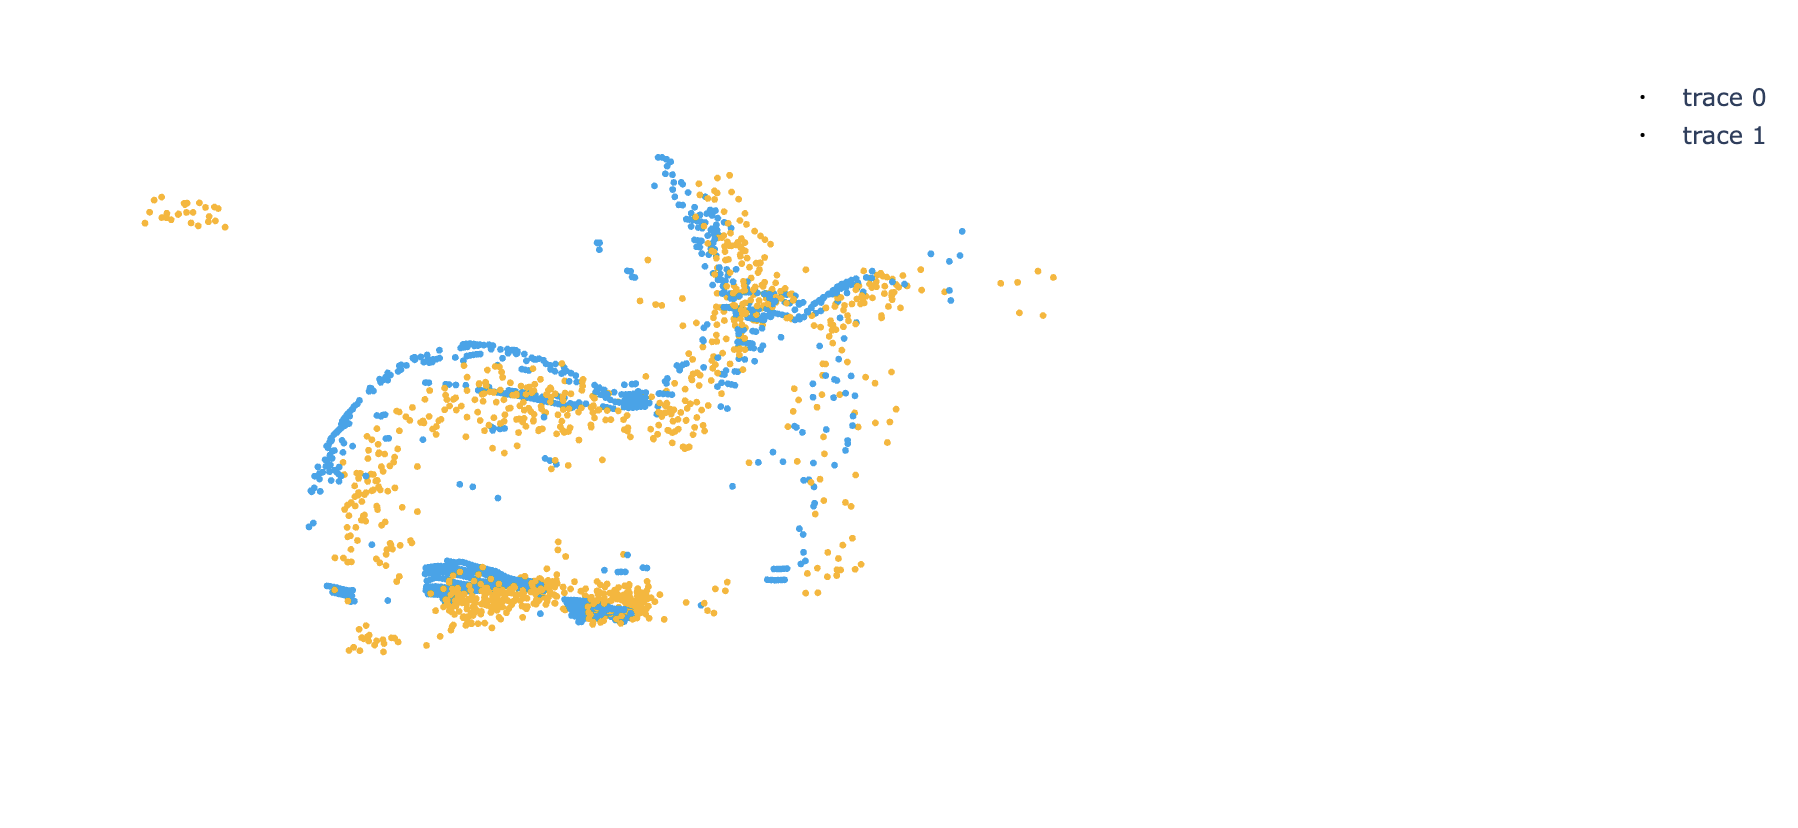

------------------

# Exercise: to develop a robust registration algorithm of 3D points using iteratively reweighted least squares

Develop a robustified version of ICP algorithm (R-ICP) that aligns two 3D point clouds by finding the transformation (rotation and translation) that minimizes the distances between corresponding points in the two clouds.

Implementation notes:

> Use a M-Estimator Charbonnier weight function with $\beta = 0.005$

> Assume that both point clouds (source and target) have the same sizes.

> Consider the point cloud extracted from the 'bunny mesh' and apply a known transformation matrix and noise.

> Compare the result of the R-ICP with the original transformation

> Compare the result of the R-ICP against the a result obtained from the original ICP method without RANSAC (aka the Vanilla ICP implementation developed in previous lecture). Discuss the results.




## b) Implement  the R-ICP method

For our R-ICP implementation we followed the algorithm present in [[2]](https://www.researchgate.net/publication/263013269_Robust_registration_of_point_sets_using_iteratively_reweighted_least_squares) that is a robust registration method of point sets using iteratively weights obtained using a Charbonnier weight function.

The R-ICP algorithm can be structured as it follows:

1. An initial transformation estimate is obtained, typically through a coarse alignment or using external information.

2. For each point in the source point cloud, the algorithm finds the nearest neighbour point in the target point cloud.

3. Taking into account the distance between the nearest neighbour each point gets a corresponding weight from the Charbonnier weight function.
For each point classified as outlier (high distance), R-ICP assigns lower weights but also assigns higher weights to inliers.

4. Then a transformation that minimizes the distance between the source points and their corresponding points in the target cloud is estimated. Robust ICP uses a weighted optimization approach that assigns higher importance to inliers and less to outliers.

5. Steps 3 and 4 are repeated iteratively, refining the transformation estimate with each iteration. The optimization process continues until convergence or a predefined stopping criterion is met.



In [60]:
## R-ICP

import numpy as np
from scipy.spatial import cKDTree
from math import sqrt

def estimate_weights_charbonnier(distance, beta=1):
    '''
    Charbonnier weight estimation function to reduce the influence of outliers.
    Input:
        distances: Nx1 array of Euclidean distances
        beta: regularization parameter to control the shape of the Charbonnier function
    Output:
        weights: Nx1 array of weights
    '''
    weights = 1 / np.sqrt(distance**2 + beta**2)
    return weights

def search_nearest_neighbor(A, B):
    '''
    Finds the nearest neighbors in B for each point in A.
    Input:
        A: Nx3 numpy array of source points
        B: Nx3 numpy array of destination points
    Output:
        distances: Nx1 array of distances to nearest neighbors
        indices: Nx1 array of indices of nearest neighbors
    '''
    tree = cKDTree(B)
    distances, indices = tree.query(A)
    return distances, indices

def calculate_transform_wlsq(A, B, weights):
    '''
    Calculates the weighted least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
      weights: Nx1 numpy array of weights for each point

    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''
    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # Compute Centroids with weights
    centroid_A = np.sum(A * weights, axis=0) / np.sum(weights)
    centroid_B = np.sum(B * weights, axis=0) / np.sum(weights)

    # Center the points around the centroids
    A_centered = A - centroid_A
    B_centered = B - centroid_B

    # Calculate Matrix C as per the IRLS-ICP paper
    C = np.zeros((m, m))
    for i in range(A.shape[0]):
        a = A_centered[i].reshape(m, 1)
        b = B_centered[i].reshape(m, 1)
        C += weights[i] * np.dot(a, b.T)
    C /= np.sum(weights)

    # Compute SVD
    U, S, Vt = np.linalg.svd(C)

    # Compute the rotation matrix R
    R = np.dot(Vt.T, U.T)

    # Special reflection case: handle improper rotations
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Optimal translation
    t = centroid_B - R @ centroid_A

    # homogeneous transformation
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

def calculate_transform_ricp(A, B, init_pose=None, max_iterations=20, tolerance=0.001):
    '''
    The RIterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD points
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    # Point clouds must have the same size
    assert A.shape == B.shape

    # Number of dimensions of the point cloud
    m = A.shape[1]

    # Initialize transformation matrix
    Tr = np.eye(m + 1)

    # Use homogeneous points and copy them to maintain the originals
    src = np.ones((m + 1, A.shape[0]))
    dst = np.ones((m + 1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)
    src_iter = np.copy(src)

    prev_error = 0

    # Consider the initial alignment transformation to source point cloud.
    if init_pose is not None:
        Tr = init_pose
        # Apply the first transformation
        src_iter = np.dot(Tr, src_iter)

    # Iterate with a stop criteria: max_iterations
    for i in range(max_iterations):

        # Compute closest points
        distances, idx = search_nearest_neighbor(src_iter[:m, :].T, dst[:m, :].T)

        # Compute Weights based on distance residuals
        weights = estimate_weights_charbonnier(distances, beta=0.005)
        weights = np.expand_dims(weights, axis=1)  # Ensure weights is Nx1 for broadcasting

        # Create arrays of corresponding points
        dst_matched = dst[:m, idx].T  # Destination points that are closest to source points

        # Compute least squares
        T, R, t = calculate_transform_wlsq(src_iter[:m, :].T, dst_matched, weights)

        # Update the source with the new transformation
        src_iter = T @ src_iter

        # Save the transformation from the actual source cloudpoint to the destination
        Tr = T @ Tr

        # Mean error: root mean square of distances
        mean_error = np.linalg.norm(src_iter[:m, :] - dst[:m, idx], axis=0).mean()

        # Stop criteria: convergence - check evolution of error
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    return Tr, distances, i, weights

In [61]:
########################################################################################################
# DO NOT CHANGE THIS CODE

# Transformation (homogeneous coordinates: R|T )
trans_init = np.asarray([[1.0, 0.0, 0.0, 0.0],
                         [0.0, 1.0, 0.0, 0.0],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

pts_source = np.asarray(bunny_source.points)
pts_target = np.asarray(bunny_target.points)

min_points = min(len(pts_source), len(pts_target))-1

# Calculate the registration matrix
Transform, distances, i, weights = calculate_transform_ricp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)
########################################################################################################
# Performance of the R-ICP

threshold  = 0.05
evaluation = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation)

draw_registration_result(bunny_source, bunny_target, Transform)
########################################################################################################

[[ 0.99993646  0.00539782  0.00989672  0.09020868]
 [-0.00881682  0.92152814  0.38821147  0.10006238]
 [-0.00702461 -0.38827406  0.92151718  0.09457158]
 [ 0.          0.          0.          1.        ]]
after ICP ::: RegistrationResult with fitness=9.750000e-01, inlier_rmse=3.642828e-03, and correspondence_set size of 975
Access transformation to get result.


#### Expected Output
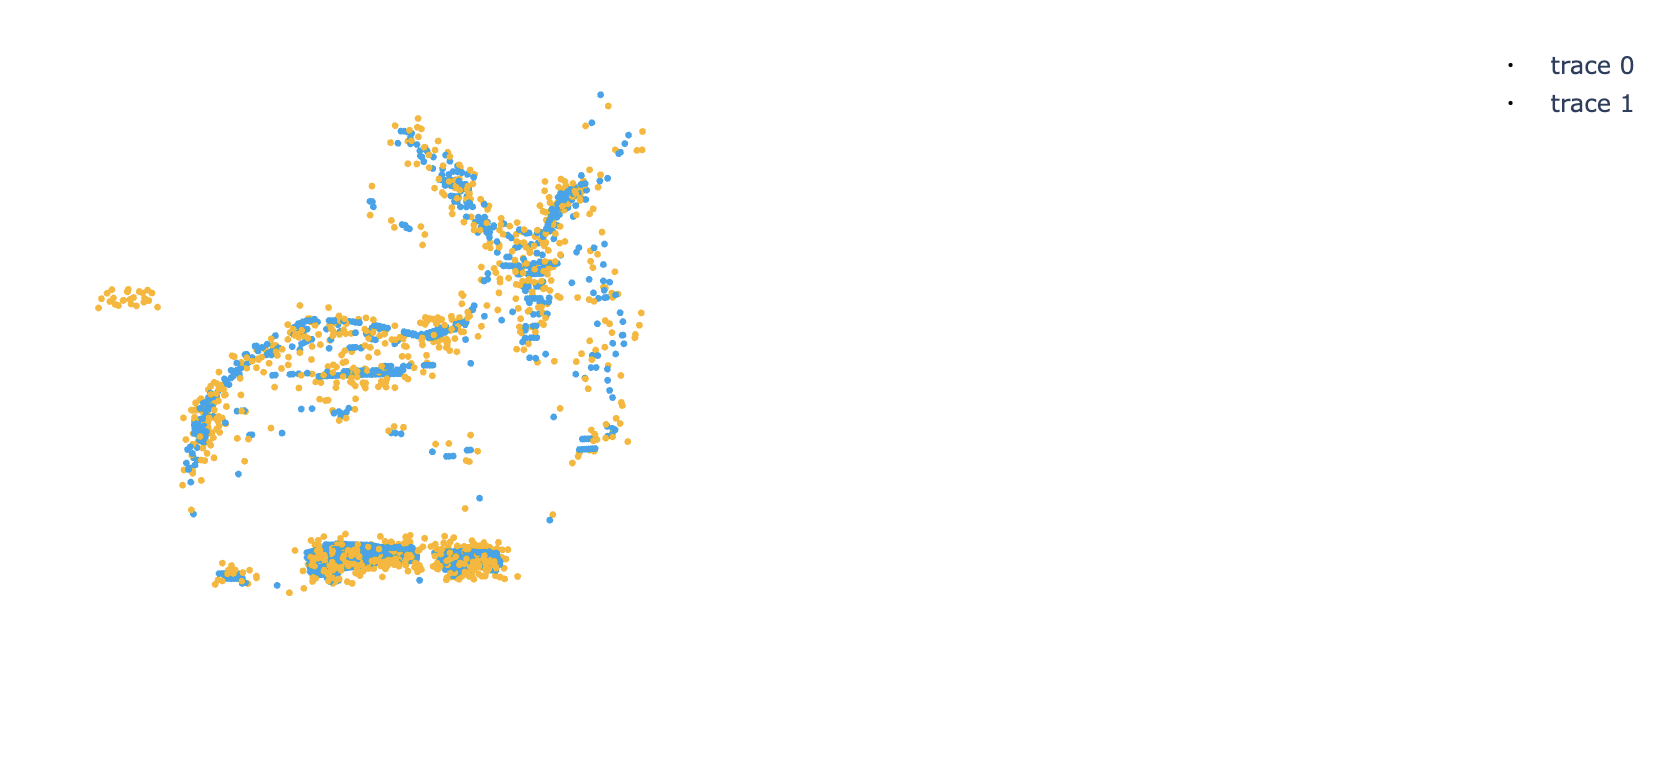

# Visualizing Weights for R-ICP Outlier Detection

In this section, we will visualize point clouds and paint them based on their corresponding weights. This can help us identify outliers after performing Robust Iterative Closest Point (R-ICP) registration.

In the standard Iterative Closest Point (ICP) algorithm, the weights for each point are typically set to one. This means that all points contribute equally to the alignment process, which can be detrimental in cases where there are outliers. Outliers can significantly affect the final transformation since their contribution is not down-weighted. Therefore, the ICP method may struggle to find an optimal registration when noise or outliers are present in the data.

On the other hand, R-ICP addresses this limitation by assigning weights to points based on their reliability or proximity to the target point cloud. Weights are calculated during the registration process, allowing the algorithm to give more importance to reliable points while down-weighting the influence of outliers. This leads to a more robust and accurate registration outcome.

## Key Points

- **Point Weighting**: R-ICP uses varying weights for different points based on their distance from the nearest point in the target cloud, allowing it to adaptively ignore outliers.
The weights are obtained from a Cherbonnier weight function.

- **Visualizing Weights**: By painting the point cloud according to these weights, we can visually assess which points are considered reliable and which are seen as potential outliers.

- **Gradient Visualization**: A gradient color scheme, where low weights are shown in yellow and high weights in blue, will help highlight points that may need further inspection or removal.

In [62]:
import numpy as np
import open3d as o3d

def paint_point_cloud_based_on_weights(points, weights):
    """
    Paints the source point cloud based on the weight values.

    Args:
    - points (numpy.ndarray): The Nx3 array of points in the point cloud.
    - weights (numpy.ndarray): The N array of weights corresponding to each point.

    Returns:
    - painted_cloud (open3d.geometry.PointCloud): The point cloud with colors based on weights.
    """

    # Normalize weights to the range [0, 1]
    min_weight = np.min(weights)
    max_weight = np.max(weights)
    normalized_weights = (weights - min_weight) / (max_weight - min_weight)

    # Create a colormap: Map normalized weights to colors
    colors = np.zeros((len(normalized_weights), 3))

    # Map normalized weights to colors
    for i in range(len(normalized_weights)):
        colors[i, 0] = normalized_weights[i]  # Red channel
        colors[i, 1] = 50  # Green channel
        colors[i, 2] = 1 - normalized_weights[i]  # Blue channel

    # Create an Open3D point cloud
    painted_cloud = o3d.geometry.PointCloud()
    painted_cloud.points = o3d.utility.Vector3dVector(points)
    painted_cloud.colors = o3d.utility.Vector3dVector(colors)

    return painted_cloud


# Paint the point cloud
painted_cloud = paint_point_cloud_based_on_weights(pts_source[:-1], weights)

# Visualize the painted point cloud
o3d.visualization.draw_geometries([painted_cloud])

<ipython-input-62-7edd968f683f>:26: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-62-7edd968f683f>:28: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)




From the previous plotted point cloud it is possible to see that we definitely have a cluster of outliers completely painted in blue.

#### Expected Output
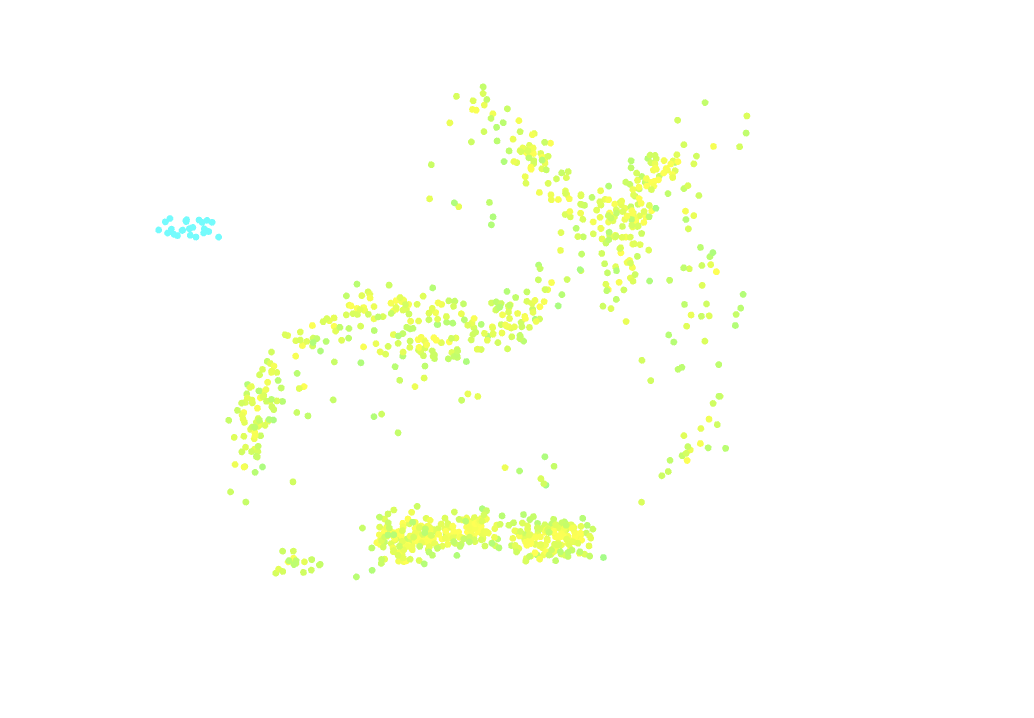

## c) Discuss the results of ICP versus R-ICP

In this section, we will compare the Iterative Closest Point (ICP) algorithm with the Robust Iterative Closest Point (R-ICP) algorithm. Both algorithms are widely used for aligning 3D point clouds, but they have fundamental differences in handling point weights and robustness against outliers.

## 1. Theoretical Background

### 1.1 Iterative Closest Point (ICP)
The ICP algorithm is a method used to minimize the distance between two point clouds. It iteratively refines the transformation (rotation and translation) to achieve the best alignment. The steps are as follows:

1. **Correspondence Selection**: For each point in the source point cloud, find the closest point in the target point cloud.
2. **Transformation Estimation**: Calculate the optimal transformation that minimizes the distance between the corresponding points.
3. **Apply Transformation**: Apply the transformation to the source point cloud.
4. **Convergence Check**: Check if the algorithm has converged (e.g., if the change in error is below a threshold).

### 1.2 Robust Iterative Closest Point (R-ICP)
R-ICP enhances the ICP algorithm by introducing a weighting scheme for the point correspondences. This allows the algorithm to down-weight outliers during the registration process, leading to a more robust alignment. The main differences include:

- Weights are calculated for each point based on their distance to the closest point in the target point cloud.
- Points that are far from their corresponding points in the target cloud receive lower weights, reducing their influence on the final transformation.

## 2. Key Differences

| Feature                         | ICP                                       | R-ICP                                     |
|---------------------------------|-------------------------------------------|-------------------------------------------|
| **Weighting Scheme**            | All points have equal weight (1).      | Varying weights based on distance/reliability. |
| **Robustness to Outliers**      | Sensitive to outliers; they can skew results significantly. | More robust; down-weights outliers to minimize their influence. |
| **Convergence Speed**           | May converge slowly in the presence of noise. | Typically faster convergence in noisy environments. |
| **Complexity**                  | Simpler implementation and lower computational cost. | More complex due to weight calculation, may require more computational resources. |
| **Final Alignment Accuracy**    | Can yield suboptimal alignment in the presence of outliers. | Generally provides more accurate alignment due to the consideration of weights. |

## 3. Performance Evaluation

### 3.1 Quantitative Metrics
- **Registration Error**: Measure the distance between the aligned point clouds. R-ICP typically exhibits lower registration error compared to ICP when outliers are present.
- **Convergence Rate**: Analyze the number of iterations needed for convergence. R-ICP often converges faster in challenging scenarios.

### 3.2 Qualitative Results
- From the evaluation results bellow it is possible to see that R-ICP leads to a lower rmse error and a better aligment as expected.

## 4. Conclusion

Both ICP and R-ICP have their strengths and weaknesses. While ICP is simpler and faster in scenarios with clean data, R-ICP provides a significant advantage in handling noise and outliers. The choice between the two algorithms largely depends on the specific application and the quality of the input data.

By understanding these differences, we can make informed decisions about which algorithm to use for various 3D point cloud alignment tasks.


### Evaluate the ICP

In [63]:
########################################################################################################
# DO NOT CHANGE THIS CODE
# Performance of the ICP

Transform, distances, i = calculate_transform_icp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)

threshold  = 0.05
evaluation_icp = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation_icp)

draw_registration_result(bunny_source, bunny_target, Transform)
########################################################################################################

[[ 0.97617103  0.00184463  0.21699476  0.09562589]
 [-0.09812493  0.89564505  0.43381037  0.09220868]
 [-0.19355007 -0.44476571  0.87448375  0.06613732]
 [ 0.          0.          0.          1.        ]]
after ICP ::: RegistrationResult with fitness=9.750000e-01, inlier_rmse=7.886049e-03, and correspondence_set size of 975
Access transformation to get result.


#### Expected Output
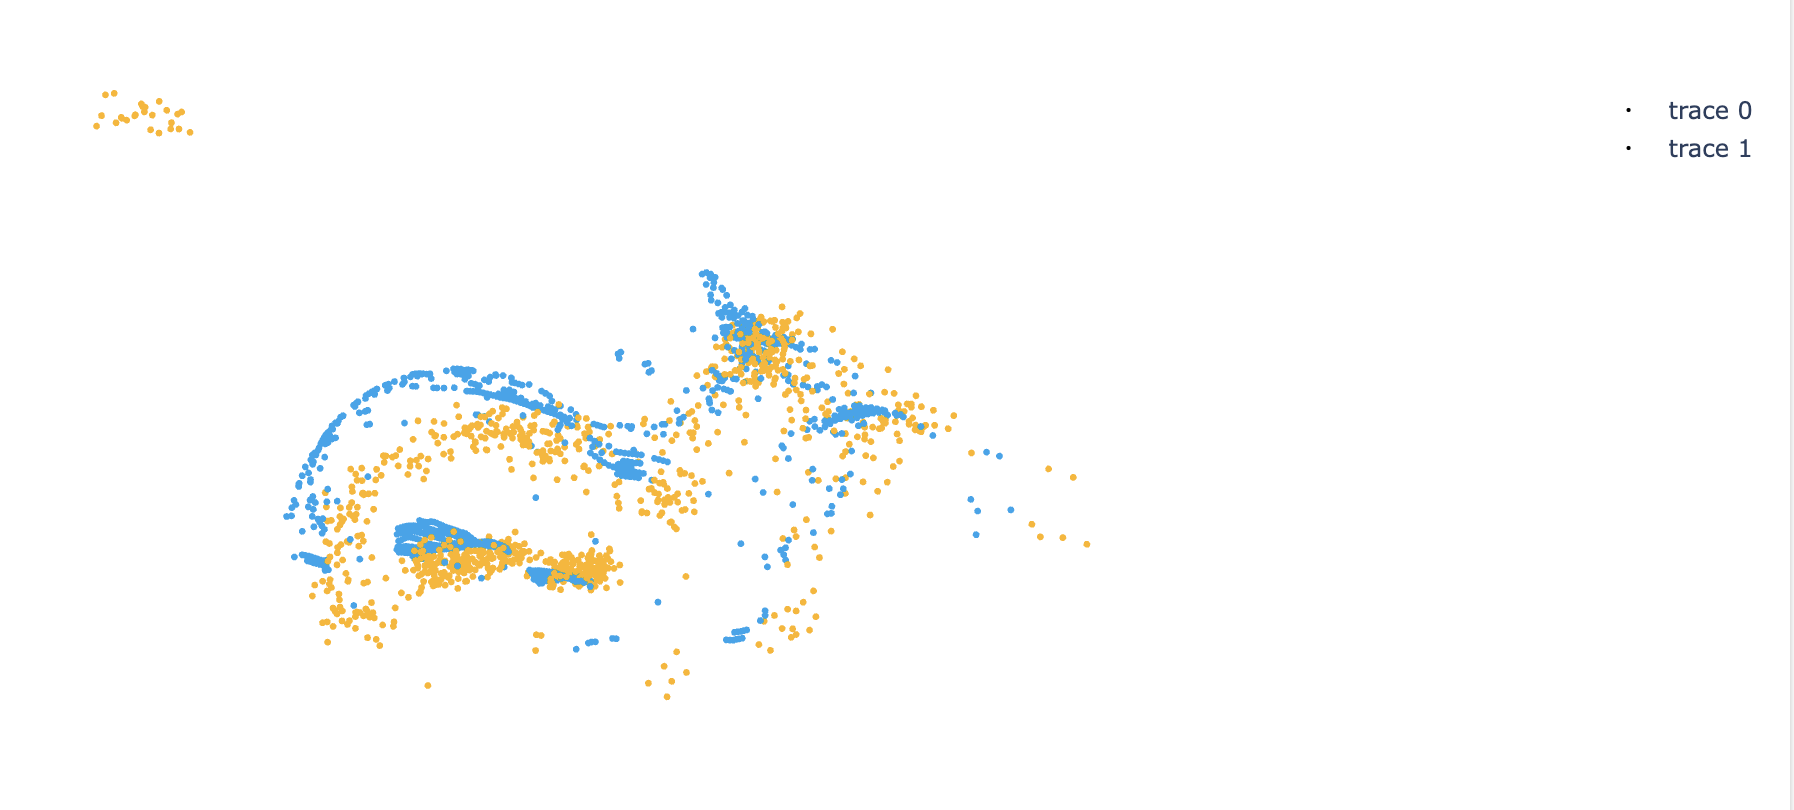

### Evaluate the R-ICP

In [64]:
# Performance of the R-ICP
Transform, distances, i, weights = calculate_transform_ricp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)

threshold  = 0.05
evaluation_ricp = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation_ricp)

draw_registration_result(bunny_source, bunny_target, Transform)

[[ 0.99993646  0.00539782  0.00989672  0.09020868]
 [-0.00881682  0.92152814  0.38821147  0.10006238]
 [-0.00702461 -0.38827406  0.92151718  0.09457158]
 [ 0.          0.          0.          1.        ]]
after ICP ::: RegistrationResult with fitness=9.750000e-01, inlier_rmse=3.642828e-03, and correspondence_set size of 975
Access transformation to get result.


#### Expected Output
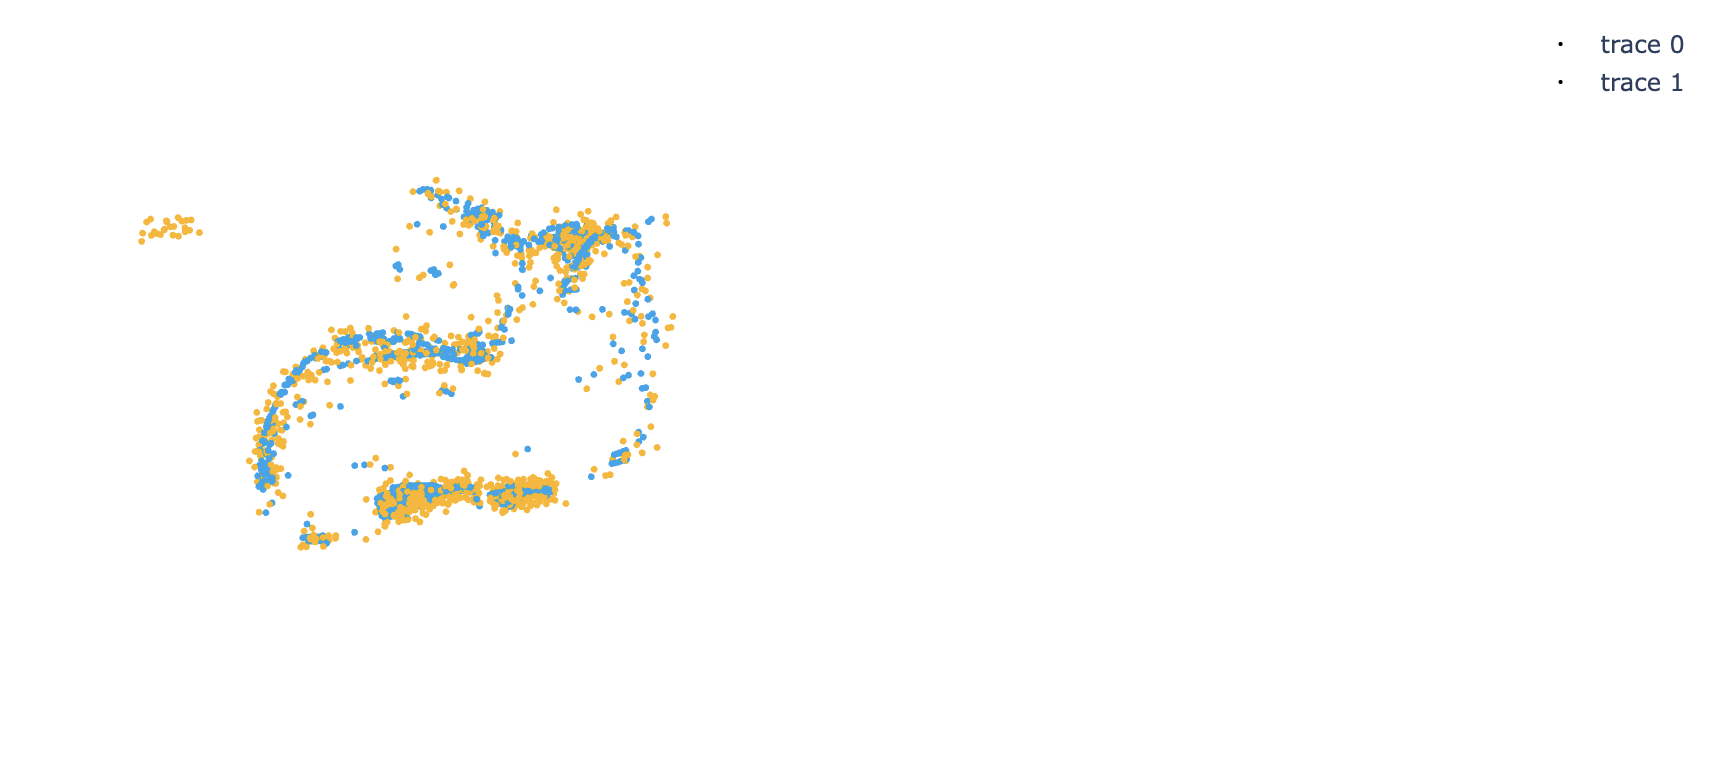

# Evaluation Metrics for ICP and R-ICP

When assessing the performance of the ICP and R-ICP algorithms, we focus on the following key metrics:

## 1. Fitness
- **Definition**: Fitness measures the quality of the alignment between the source and target point clouds after registration. It quantifies how well the points from the source cloud correspond to the points in the target cloud.
- **Interpretation**: Higher fitness values indicate a better match, meaning the point clouds are well aligned.

## 2. Inlier RMSE (Root Mean Square Error)
- **Definition**: Inlier RMSE is the average distance between the inlier correspondences of the aligned point clouds. It provides an indication of how closely the aligned points are positioned relative to each other.
- **Interpretation**: Lower RMSE values suggest a more accurate alignment. High RMSE values may indicate misalignment or the influence of outliers.

## 3. Correspondence Set Size
- **Definition**: This metric represents the number of point correspondences used in the evaluation of the alignment.
- **Interpretation**: A larger correspondence set size generally implies a more robust registration process, as it indicates that more points were deemed reliable for alignment.

In [65]:
import pandas as pd

# Create a DataFrame with the evaluation metrics
data = {
    'Metric': ['Fitness', 'Inlier RMSE', 'Correspondence Set Size'],
    'ICP': [evaluation_icp.fitness, evaluation_icp.inlier_rmse, len(evaluation_icp.correspondence_set)],
    'R-ICP': [evaluation_ricp.fitness, evaluation_ricp.inlier_rmse, len(evaluation_ricp.correspondence_set)]
}

comparison_df = pd.DataFrame(data)

# Display the DataFrame
comparison_df

,Metric,ICP,R-ICP
0,Fitness,0.975000,0.975000
1,Inlier RMSE,0.007886,0.003643
2,Correspondence Set Size,975.000000,975.000000


# General Issues in ICP and R-ICP Algorithms

The Iterative Closest Point (ICP) and Robust Iterative Closest Point (R-ICP) algorithms are widely used for point cloud registration, where the goal is to align two 3D datasets. However, both algorithms have inherent limitations that can impact their performance and accuracy.

## 1. Sensitivity to Initial Alignment
- **Issue**: Both ICP and R-ICP rely on an initial alignment between the source and target point clouds. If the initial transformation is too far from the optimal solution, the algorithms may converge to a local minimum, resulting in poor alignment.
- **Impact**: Misalignment or incorrect transformations are common in cases with significant initial misalignment. Proper initialization is crucial for both algorithms.

## 2. Convergence to Local Minima
- **Issue**: Due to the iterative nature of these algorithms, they often converge to the nearest local minimum rather than the global optimum. This is especially problematic for datasets with non-uniform distributions or complex geometries.
- **Impact**: This issue can lead to suboptimal transformations, particularly in scenes with repetitive structures or symmetric shapes. Refinement techniques or multi-resolution approaches may be needed.

## 3. Dependence on Correspondences
- **Issue**: ICP and R-ICP rely on finding correspondences between points in the source and target clouds. When correspondences are sparse, incomplete, or noisy, the algorithms can struggle to find accurate transformations.
- **Impact**: Registration accuracy drops significantly in cases of occlusion, incomplete data, or noise. This is a common challenge in real-world applications where point clouds may have missing areas or variable densities.

## 4. Handling of Outliers
- **Issue**: Outliers can negatively impact standard ICP by skewing the calculated transformation due to equal weighting of all points. While R-ICP addresses this by down-weighting outliers, it is not always foolproof, especially in heavily cluttered or noisy scenes.
- **Impact**: Outliers can lead to misalignment, particularly in environments with multiple small objects or significant noise. The R-ICP algorithm mitigates this to some extent but may still struggle with dense outliers.

## 5. Computational Complexity
- **Issue**: Both algorithms can be computationally expensive, especially for large point clouds. The nearest neighbor search required for correspondence finding is a significant bottleneck.
- **Impact**: Processing time can be lengthy for large datasets, making real-time applications challenging. Optimization techniques, such as down-sampling or using approximate nearest neighbor searches, are often necessary to reduce computation time.

## 6. Sensitivity to Parameter Selection
- **Issue**: Parameters like the convergence threshold, maximum iterations, and, in R-ICP, weighting functions, significantly impact the outcome. Improper tuning can result in either slow convergence or poor registration accuracy.
- **Impact**: In practice, tuning these parameters for specific datasets is often trial-and-error and may require substantial testing to achieve optimal results.

### Summary
While ICP and R-ICP are powerful tools for point cloud registration, these common issues can limit their effectiveness in real-world applications. Understanding these limitations is crucial for improving registration accuracy and for selecting appropriate pre-processing and post-processing steps.


# Sensitivity to Initial Alignment: Example

In the following example, we demonstrate the sensitivity of both ICP and R-ICP to the initial alignment. We apply a rotation of π (180 degrees) around the Z-axis to the source point cloud before attempting registration. This poor initial alignment prevents both methods from converging to the correct final transformation, highlighting the importance of starting with a close initial estimate. Algorithms such as Principal Component Analysis
(PCA) can be used to mitigate this problem.

In [66]:
########################################################################################################
# DO NOT CHANGE THIS CODE

# Load MESH Bunny
bunny            = o3d.data.BunnyMesh()
mesh             = o3d.io.read_triangle_mesh(bunny.path)
mesh.compute_vertex_normals()
pcd              = o3d.geometry.PointCloud()
pcd.points       = mesh.vertices   # use vertexes as points
pcd_bunny        = o3d.geometry.PointCloud()

pcd_bunny.points = pcd.points[10:1010]       # use only partial pts

#Copy pts
bunny_target    = copy.deepcopy(pcd_bunny)

# Generate some noise
num_points       = len(pcd_bunny.points)
points_noise     = np.random.rand(num_points, 3)/100
np_pointcloud    = np.asarray(pcd_bunny.points)
for i in range(num_points) :
    np_pointcloud[i, 0] += points_noise[i, 0]
    np_pointcloud[i, 1] += points_noise[i, 1]
    np_pointcloud[i, 2] += points_noise[i, 2]
np_pointcloud [:-25] = np_pointcloud [:-25] - 0.1


bunny_source = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(np_pointcloud))

## APPLY a known rotation and translation
R = pcd_bunny.get_rotation_matrix_from_xyz((np.pi/8, 0, np.pi))    # Prepare rotation matrix
H         = np.eye(4)                                         # Prepare Transformation matrix
H[:3, :3] = R
H[0, 3]   = 0.005
H[1, 3]   = -0.005
H[2, 3]   = -0.003
print(H)

# Apply translation to the point cloud "bunny_source"
bunny_source.transform(H)
########################################################################################################

[[-1.00000000e+00 -1.22464680e-16  0.00000000e+00  5.00000000e-03]
 [ 1.13142611e-16 -9.23879533e-01 -3.82683432e-01 -5.00000000e-03]
 [ 4.68652041e-17 -3.82683432e-01  9.23879533e-01 -3.00000000e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


PointCloud with 1000 points.

In [67]:
########################################################################################################
# DO NOT CHANGE THIS CODE
# Performance of the ICP

Transform, distances, i = calculate_transform_icp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)

threshold  = 0.05
evaluation_icp = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation_icp)

draw_registration_result(bunny_source, bunny_target, Transform)
########################################################################################################

[[ 0.97617103  0.00184463  0.21699476  0.09562589]
 [-0.09812493  0.89564505  0.43381037  0.09220868]
 [-0.19355007 -0.44476571  0.87448375  0.06613732]
 [ 0.          0.          0.          1.        ]]
after ICP ::: RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


#### Expected Output
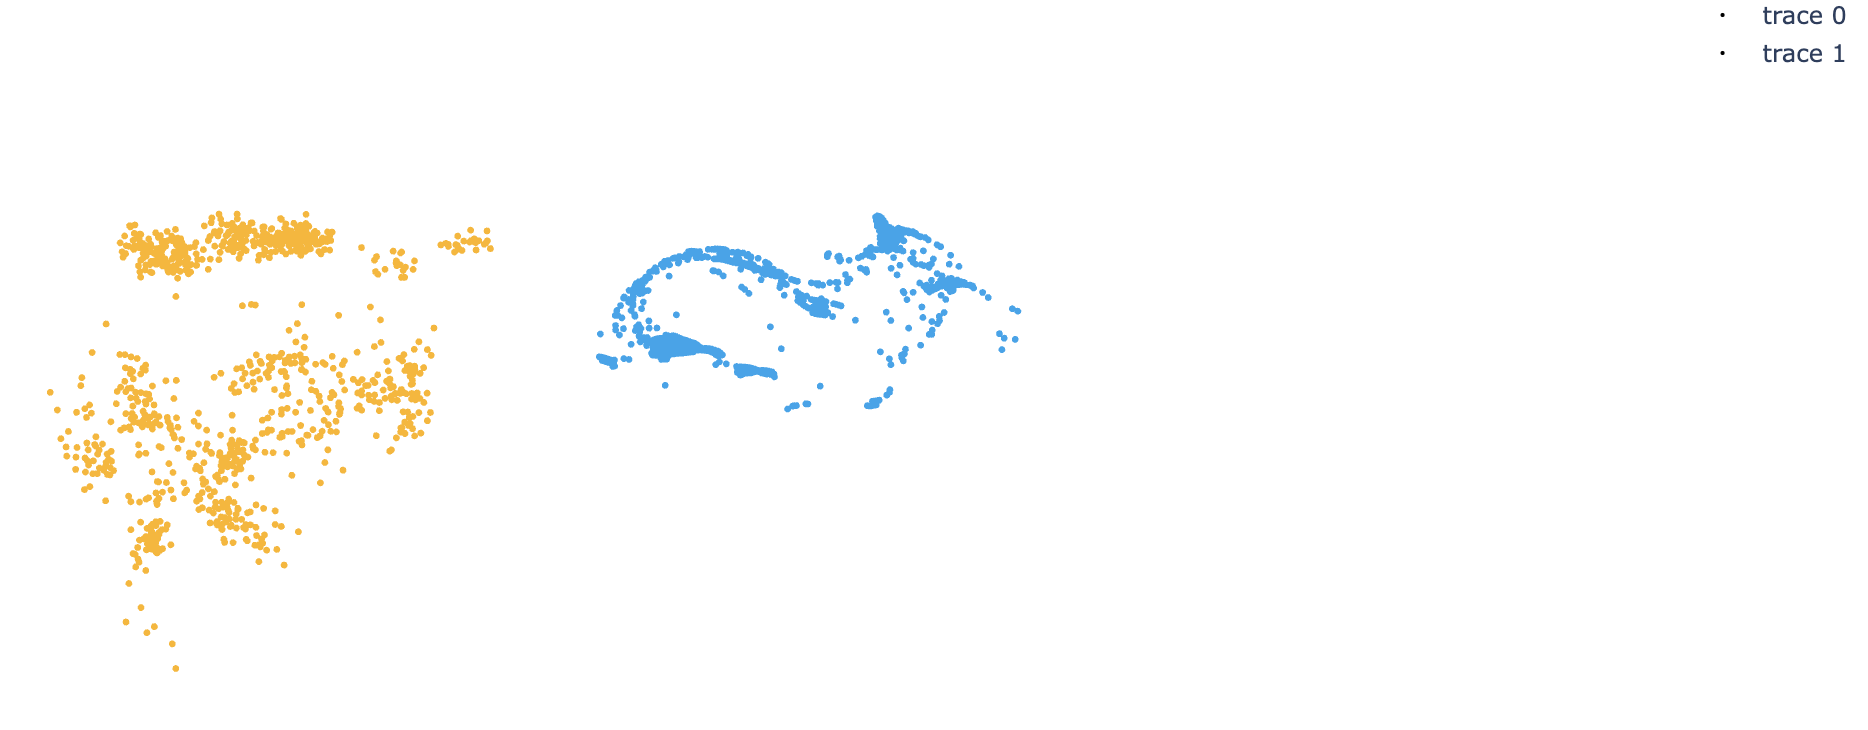

In [68]:
# Performance of the R-ICP
Transform, distances, i, weights = calculate_transform_ricp(pts_source[:min_points, :], pts_target[:min_points, :], trans_init, 100, 0.0000001)
print(Transform)

threshold  = 0.05
evaluation_ricp = o3d.pipelines.registration.evaluate_registration(bunny_source, bunny_target, threshold, Transform)
print('after ICP :::', evaluation_ricp)

draw_registration_result(bunny_source, bunny_target, Transform)

[[ 0.99993646  0.00539782  0.00989672  0.09020868]
 [-0.00881682  0.92152814  0.38821147  0.10006238]
 [-0.00702461 -0.38827406  0.92151718  0.09457158]
 [ 0.          0.          0.          1.        ]]
after ICP ::: RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


#### Expected Output

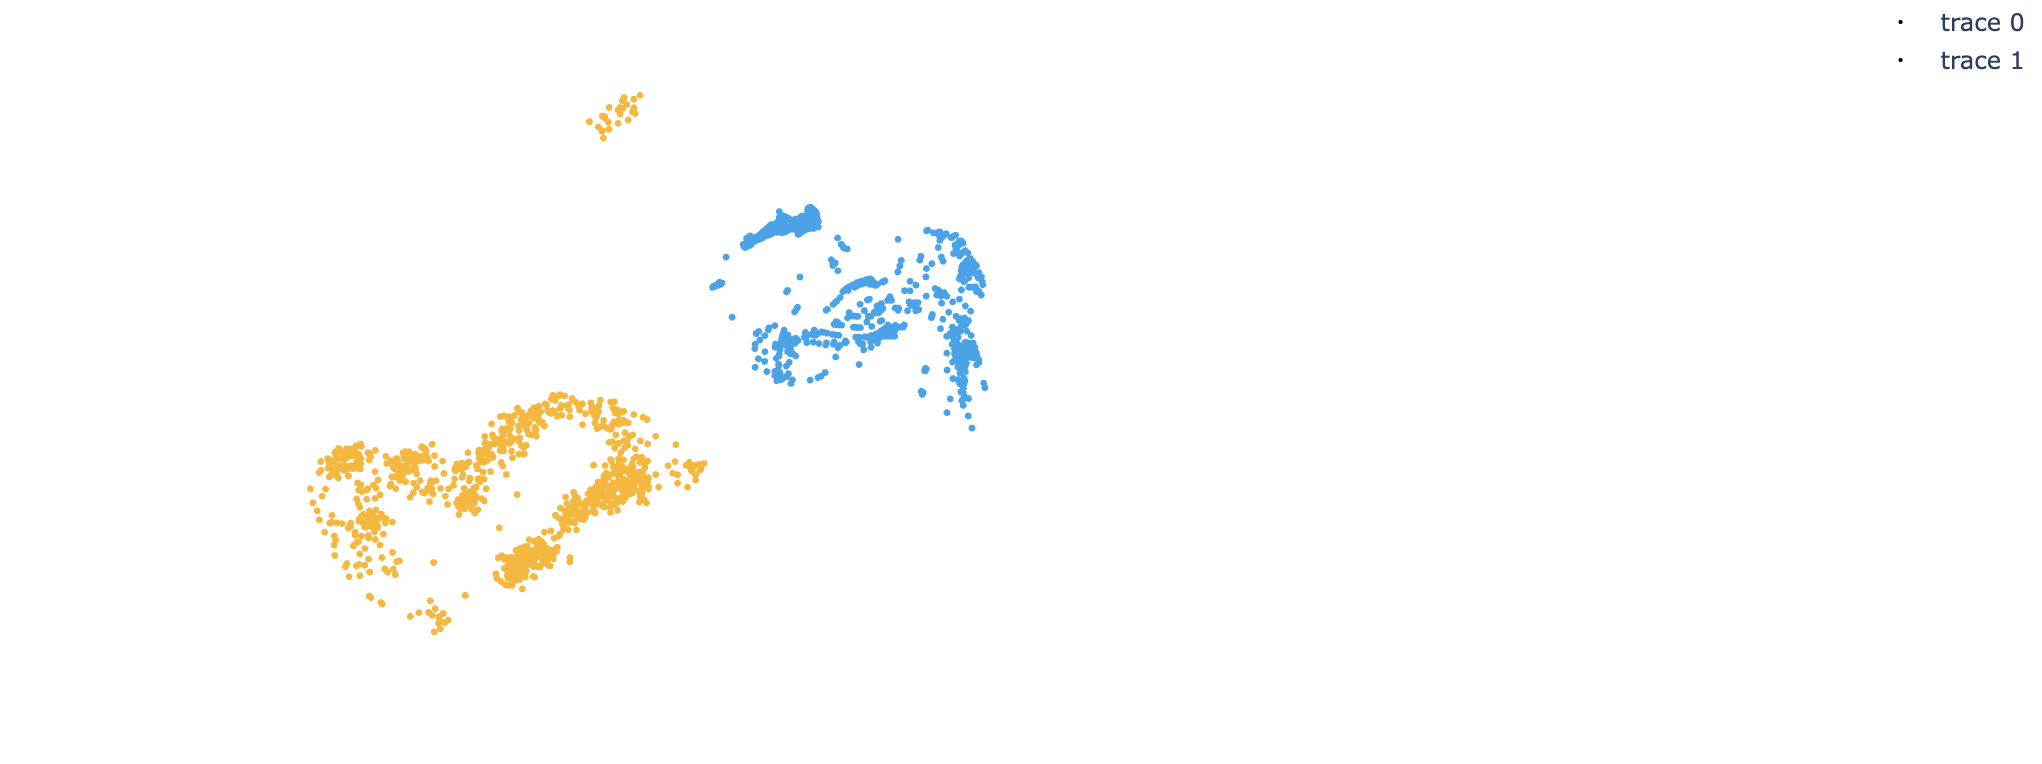

--------------------------
--------------------------